<a href="https://colab.research.google.com/github/ankitog/Deep-learning-Repo/blob/master/Transfer_learning_(Aunts_and_Bees).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!ls ~/.kaggle

kaggle.json


In [0]:
!chmod 600 /root/.kaggle/kaggle.json  # set permission

In [0]:
!kaggle datasets download -d ajayrana/hymenoptera-data -p /content/drive/My\ Drive/Kaggle/auntsANDbees/

 84% 76.0M/90.2M [00:00<00:00, 155MB/s]
100% 90.2M/90.2M [00:00<00:00, 154MB/s]


In [0]:
import os
os.chdir('/content/drive/My Drive/Kaggle/padhai-hindi-vowel')

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [0]:
data_dir = '/content/drive/My Drive/Kaggle/auntsANDbees/hymenoptera_data'

image_dataset = {x : datasets.ImageFolder(os.path.join(data_dir, x), transform= data_transforms[x] )  for x in ['train', 'val']}

dataloaders = {x : torch.utils.data.DataLoader(image_dataset[x], batch_size =4, shuffle=True, num_workers=4) 
for x in ['train', 'val']}

In [0]:
dataset_sizes = {x : len(image_dataset[x]) for x in ['train', 'val']}
class_names = image_dataset['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
device

device(type='cuda', index=0)

In [0]:
img, lbl = next(iter(dataloaders['train']))
print(img.size())
print(lbl.size())

torch.Size([4, 3, 224, 224])
torch.Size([4])


In [0]:
def imshow(img):
  img = np.transpose(img.numpy(), (1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['ants', 'ants', 'ants', 'bees']


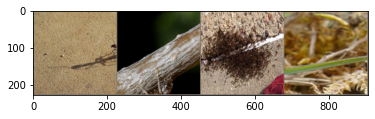

In [0]:
imshow(torchvision.utils.make_grid(img))
print([class_names[lbl[i].item()] for i in range(4)])

In [0]:
def evaluation(model, dataloader):
  total, correct = 0, 0
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, pred = torch.max(outputs, 1)
      total += labels.size(0)
      correct += torch.sum(pred == labels.data).item()
  return 100 * correct/total

In [0]:
%%time
max_epoch = 25
for i in range(max_epoch):
  for inputs, labels in dataloaders['train']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  print('Epoch: {}/{}'.format(i, max_epoch -1))


In [0]:
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(model, dataloaders['val']), evaluation(model, dataloaders['train'])))

In [0]:
def train_model_prac(model, criterion, optimizer, scheduler, num_epochs = 25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
          scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase] 
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
  model.load_state_dict(best_model_wts)
  return model
  


In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **Resnet with batch normalization**

In [0]:
model = models.resnet18(pretrained=True)

for params in model.parameters():
  params.requires_grad =  False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
for params in model.parameters():
  if params.requires_grad:
    print(params.shape)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

torch.Size([2, 512])
torch.Size([2])


In [0]:
model = train_model_prac(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

In [0]:
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(model, dataloaders['val']), evaluation(model, dataloaders['train'])))

Test acc: 94.77, Train acc: 95.08


# **VGG16 with batch normalization**

In [0]:
model = models.vgg16_bn(pretrained=True)
for params in model.parameters():
  params.requires_grad = False

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 2)

for params in model.parameters():
  if params.requires_grad:
    print(params.shape)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

torch.Size([2, 4096])
torch.Size([2])


In [0]:
model = train_model_prac(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5417 Acc: 0.7582
val Loss: 0.3030 Acc: 0.9085
Epoch 1/24
----------
train Loss: 0.3279 Acc: 0.8484
val Loss: 0.1987 Acc: 0.9412
Epoch 2/24
----------
train Loss: 0.3147 Acc: 0.8566
val Loss: 0.1798 Acc: 0.9281
Epoch 3/24
----------
train Loss: 0.4199 Acc: 0.8320
val Loss: 0.2308 Acc: 0.9216
Epoch 4/24
----------
train Loss: 0.3467 Acc: 0.8484
val Loss: 0.3043 Acc: 0.9020
Epoch 5/24
----------
train Loss: 0.2862 Acc: 0.8852
val Loss: 0.2213 Acc: 0.9150
Epoch 6/24
----------
train Loss: 0.2162 Acc: 0.8934
val Loss: 0.2081 Acc: 0.9412
Epoch 7/24
----------
train Loss: 0.2823 Acc: 0.8934
val Loss: 0.1999 Acc: 0.9216
Epoch 8/24
----------
train Loss: 0.2956 Acc: 0.8852
val Loss: 0.1861 Acc: 0.9281
Epoch 9/24
----------
train Loss: 0.1910 Acc: 0.9139
val Loss: 0.2112 Acc: 0.9150
Epoch 10/24
----------
train Loss: 0.2137 Acc: 0.9139
val Loss: 0.1942 Acc: 0.9281
Epoch 11/24
----------
train Loss: 0.2888 Acc: 0.8648
val Loss: 0.2001 Acc: 0.9346
Epoch 12/24
--

In [0]:
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(model, dataloaders['val']), evaluation(model, dataloaders['train'])))

Test acc: 94.12, Train acc: 93.85


In [0]:
model = models.resnet50(pretrained=True)
for params in model.parameters():
  params.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

for params in model.parameters():
  if params.requires_grad:
    print(params.shape)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

torch.Size([2, 2048])
torch.Size([2])


In [0]:
model = train_model_prac(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6080 Acc: 0.6598
val Loss: 0.2068 Acc: 0.9412
Epoch 1/24
----------
train Loss: 0.5426 Acc: 0.7500
val Loss: 0.4156 Acc: 0.8301
Epoch 2/24
----------
train Loss: 0.3843 Acc: 0.8197
val Loss: 0.2177 Acc: 0.8954
Epoch 3/24
----------
train Loss: 0.4320 Acc: 0.8074
val Loss: 0.1372 Acc: 0.9542
Epoch 4/24
----------
train Loss: 0.4110 Acc: 0.8402
val Loss: 0.2745 Acc: 0.8889
Epoch 5/24
----------
train Loss: 0.3785 Acc: 0.8361
val Loss: 0.1476 Acc: 0.9477
Epoch 6/24
----------
train Loss: 0.2961 Acc: 0.8730
val Loss: 0.1580 Acc: 0.9281
Epoch 7/24
----------
train Loss: 0.3486 Acc: 0.8402
val Loss: 0.1275 Acc: 0.9542
Epoch 8/24
----------
train Loss: 0.2977 Acc: 0.8811
val Loss: 0.1408 Acc: 0.9412
Epoch 9/24
----------
train Loss: 0.3666 Acc: 0.8238
val Loss: 0.1453 Acc: 0.9412
Epoch 10/24
----------
train Loss: 0.3722 Acc: 0.8361
val Loss: 0.1639 Acc: 0.9216
Epoch 11/24
----------
train Loss: 0.3969 Acc: 0.8238
val Loss: 0.1618 Acc: 0.9216
Epoch 12/24
--

In [0]:
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(model, dataloaders['val']), evaluation(model, dataloaders['train'])))

Test acc: 95.42, Train acc: 97.13


In [0]:
model.state_dict()

In [0]:
os.chdir(data_dir)
os.getcwd()

'/content/drive/My Drive/Kaggle/auntsANDbees/hymenoptera_data'

In [0]:
torch.save(model.state_dict(), 'tensor.pt' )

In [0]:
visualize_model(model_ft)